In [6]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from tqdm import tqdm
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [7]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

eco.optimize()
bsub.optimize()

<Solution 0.12 at 0x7f409bde0160>

In [23]:
me.solution

<Solution 0.10 at 0x7f40a84f97b8>

In [15]:
with open('./me_models/iYO844b.pickle', 'rb') as f:
    me = pickle.load(f)
with open('./me_models/final/iJL1678b.pickle', 'rb') as f:
    ecome = pickle.load(f)

In [20]:
me.metabolites.protein_BSU03040.translation_data.amino_acid_sequence

'MFAKRFKTSLLPLFAGFLLLFHLVLAGPAAASAETANKSNELTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVKEGNQGDKSMSNWYWLYQPTSYQIGNRYLGTEQEFKEMCAAAEEYGIKVIVDAVINHTTSDYAAISNEVKSIPNWTHGNTQIKNWSDRWDVTQNSLLGLYDWNTQNTQVQSYLKRFLDRALNDGADGFRFDAAKHIELPDDGSYGSQFWPNITNTSAEFQYGEILQDSASRDAAYANYMDVTASNYGHSIRSALKNRNLGVSNISHYASDVSADKLVTWVESHDTYANDDEESTWMSDDDIRLGWAVIASRSGSTPLFFSRPEGGGNGVRFPGKSQIGDRGSALFEDQAITAVNRFHNVMAGQPEELSNPNGNNQIFMNQRGSHGVVLANAGSSSVSINTATKLPDGRYDNKAGAGSFQVNDGKLTGTINARSVAVLYPDDIAKAPHVFLENYKTGVTHSFNDQLTITLRADANTTKAVYQINNGPETAFKDGDQFTIGKGDPFGKTYTIMLKGTNSDGVTRTEKYSFVKRDPASAKTIGYQNPNHWSQVNAYIYKHDGSRVIELTGSWPGKPMTKNADGIYTLTLPADTDTTNAKVIFNNGSAQVPGQNQPGFDYVLNGLYNDSGLSGSLPH'

In [16]:
get_reactions_of_met(me,'protein_BSU03040_Inner_Membrane')

( formation_BSU03040-MONOMER 0.0 1000.0 ) 	 protein_BSU03040_Inner_Membrane --> BSU03040-MONOMER
( translocation_BSU03040 0.0 1000.0 ) 	 26.36 atp_c + 26.36 h2o_c + protein_BSU03040 --> -0.00915277777777778*mu BSU27650-MONOMER + -0.00915277777777778*mu BSU35300-MONOMER + -0.00915277777777778*mu SRP-CPLX + 26.36 adp_c + 26.36 h_c + 26.36 pi_c + protein_BSU03040_Inner_Membrane + -0.00915277777777778*mu secYEG


[<ComplexFormation formation_BSU03040-MONOMER at 0x7f40a8c94128>,
 <PostTranslationReaction translocation_BSU03040 at 0x7f40a82b3630>]

In [66]:
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 208.757804 seconds
Finished substituting S,lb,ub in 8.916274 seconds
Finished makeME_LP in 1.071229 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 8.897109 seconds
Finished makeME_LP in 1.287711 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 8.767394 seconds
Finished makeME_LP in 1.073602 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 8.960964 seconds
Finished makeME_LP in 1.066881 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.03125 0.03125 1
Finished substituting S,lb,ub in 8.884194 seconds
Finished makeME_LP in 1.068705 seconds
Getting MINOS parameters from ME_NLP...
5 0.0 0.0 0.015625 0.015625 1
Finished substituting S,lb,ub in 8.863671 seconds
Finished makeME_LP in 1.089472 seconds
Getting MINOS parameters from ME_NLP.

In [5]:
solve_me_model(ecome, 1., min_mu = .1, precision=1e-6, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 421.270160 seconds
Finished substituting S,lb,ub in 16.019758 seconds
Finished makeME_LP in 1.913121 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 16.846839 seconds
Finished makeME_LP in 1.877419 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 15.869163 seconds
Finished makeME_LP in 1.891475 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 15.847416 seconds
Finished makeME_LP in 1.871226 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 15.806131 seconds
Finished makeME_LP in 1.899086 seconds
Getting MINOS parameters from ME_NLP...
5 0.84375 0.84375 0.875 0.84375 optimal
Finished substituting S,lb,ub in 15.944288 seconds
Finished makeME_LP in 1.919528 seconds
Get

In [6]:
df = exchange_single_model(ecome)
df.to_csv('temp_result.csv')

In [7]:
with open('./me_models/solution.pickle', 'wb') as solution:
    pickle.dump(me,solution)

In [8]:
with open('./me_models/ecoli_solution.pickle', 'wb') as solution:
    pickle.dump(ecome,solution)

# Postprocessing

In [97]:
with open('./me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)
with open('./me_models/ecoli_solution.pickle', 'rb') as solution:
    ecome = pickle.load(solution)

In [105]:
b

,mass
EX_ca2_e,0.000000
EX_co2_e,-0.263207
EX_fe3_e,0.000000
EX_glc__D_e,0.306265
EX_h2o_e,-0.141777
EX_h_e,-0.000774
EX_k_e,0.003258
EX_mg2_e,0.000000
EX_nh4_e,0.017046
EX_o2_e,0.182582


In [99]:
me.solution

<Solution 0.10 at 0x7fe4b52ef6a0>

In [22]:
# Exchange
df_m = exchange_single_model(bsub)
df = exchange_single_model(me)
df.join(df_m['flux'],lsuffix='_me',rsuffix='_m')

,name,reaction,lower_bound,upper_bound,flux_me,flux_m
id,,,,,,
EX_co2_e,,co2_e <=>,-999999.0,999999.0,6.044848e+00,5.980676
EX_cobalt2_e,,cobalt2_e <=>,-1000.0,0.0,-4.867374e-08,NaN
EX_glc__D_e,,glc__D_e <=>,-1.7,999999.0,-1.699997e+00,-1.700000
EX_h2o_e,,h2o_e <=>,-999999.0,999999.0,8.428705e+00,7.869819
EX_h_e,,h_e <=>,-999999.0,999999.0,7.865889e-01,0.767665
EX_k_e,,k_e <=>,-999999.0,999999.0,-1.808057e-07,-0.083321
EX_mg2_e,,mg2_e <=>,-999999.0,999999.0,-1.300238e-03,-0.011999
EX_mn2_e,,mn2_e <=>,-1000.0,0.0,-2.371824e-06,NaN
EX_nh4_e,,nh4_e <=>,-5.0,999999.0,-9.471223e-01,-0.944964


In [23]:
# Solution summary
summary_df = solution_summary(me)
summary_m_df = solution_summary(bsub)
summary_df.to_csv('./solution_summary.csv')

100%|██████████| 1250/1250 [00:02<00:00, 572.97it/s]


In [24]:
summary_df = solution_summary(me)

100%|██████████| 6282/6282 [00:43<00:00, 145.01it/s]


## Compare M/ME with ecoli

In [25]:
_,rxn_id_dict = homogenize_reactions(model=bsub,ref_model=eco)

100%|██████████| 1250/1250 [00:00<00:00, 4452.99it/s]


In [26]:
# M - ME comparison of metabolic fluxes in Bacillus
flux_dict = me.get_metabolic_flux()
me_flux_df = pd.DataFrame.from_dict({'flux':flux_dict}).rename(index=rxn_id_dict)
comparison_df = summary_m_df.join(me_flux_df,lsuffix='_m',rsuffix='_me')
comparison_df[abs(comparison_df.flux_m)>0]

,lb,ub,flux_m,formula,flux_me
2S6HCCi,0,999999,3.13791e-05,akg_c + h_c + ichor_c --> 2shchc_c + co2_c + p...,0.000027
ACACT1r,-999999,999999,0.00330023,2.0 accoa_c <=> aacoa_c + coa_c,0.002846
ACACT2r,-999999,999999,0.00330023,accoa_c + btcoa_c <=> 3ohcoa_c + coa_c,0.002846
ACACT3r,-999999,999999,0.00330023,accoa_c + hxcoa_c <=> 3oocoa_c + coa_c,0.002846
ACACT4r,-999999,999999,0.00330023,accoa_c + occoa_c <=> 3odcoa_c + coa_c,0.002846
...,...,...,...,...,...
UMPK,0,999999,0.0383322,atp_c + ump_c --> adp_c + udp_c,0.055363
URIDK2r_copy1,0,999999,999999,atp_c + dump_c --> adp_c + dudp_c,0.000000
URIDK2r_copy2,-999999,999999,-999999,atp_c + dump_c <=> adp_c + dudp_c,-0.004859
VALDHr,-999999,999999,999998,h2o_c + nad_c + val__L_c <=> 3mob_c + h_c + na...,0.000000


In [28]:
# M - ME comparison of metabolic fluxes in E. coli
summary_df_ecoli = solution_summary(ecome)
summary_m_df_ecoli = solution_summary(eco)

flux_dict_ecoli = ecome.get_metabolic_flux()
comparison_df_ecoli = summary_m_df_ecoli.join(\
                    pd.DataFrame.from_dict({'flux':flux_dict_ecoli}),lsuffix='_m',rsuffix='_me')

100%|██████████| 2583/2583 [00:04<00:00, 611.36it/s]


In [29]:
summary_m_df[summary_m_df.flux > 0]

,lb,ub,flux,formula
2S6HCCi,0,999999,3.13791e-05,akg_c + h_c + ichor_c --> 2shchc_c + co2_c + p...
ACACT1r,-999999,999999,0.00330023,2.0 accoa_c <=> aacoa_c + coa_c
ACACT2r,-999999,999999,0.00330023,accoa_c + btcoa_c <=> 3ohcoa_c + coa_c
ACACT3r,-999999,999999,0.00330023,accoa_c + hxcoa_c <=> 3oocoa_c + coa_c
ACACT4r,-999999,999999,0.00330023,accoa_c + occoa_c <=> 3odcoa_c + coa_c
...,...,...,...,...
UGT2_BS,0,999999,0.000778578,0.01 12dgr_BS_c + 3.0 udpg_c --> 3.0 h_c + 0.0...
UGT_BS,0,999999,0.00184028,0.01 12dgr_BS_c + 2.0 udpg_c --> 0.01 d12dg_BS...
UMPK,0,999999,0.0383322,atp_c + ump_c --> adp_c + udp_c
URIDK2r_copy1,0,999999,999999,atp_c + dump_c --> adp_c + dudp_c


Text(0.5, 1.0, 'E. coli')

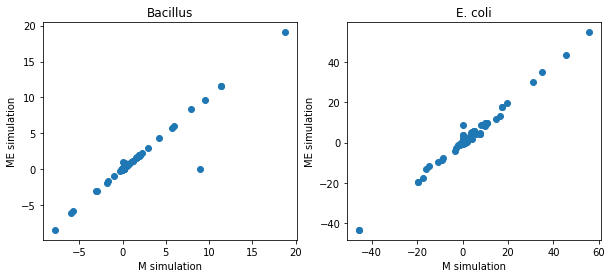

In [31]:
import matplotlib.pyplot as plt
threshold = 100
temp_df = comparison_df[abs(comparison_df.flux_m)<threshold]
temp_df_ecoli = comparison_df_ecoli[abs(comparison_df_ecoli.flux_m)<threshold]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(temp_df['flux_m'],temp_df['flux_me'])
plt.xlabel('M simulation')
plt.ylabel('ME simulation')
plt.title('Bacillus')

plt.subplot(1,2,2)
plt.scatter(temp_df_ecoli['flux_m'],temp_df_ecoli['flux_me'])
plt.xlabel('M simulation')
plt.ylabel('ME simulation')
plt.title('E. coli')


In [32]:
# Store results to visualize in Escher
comparison_df['flux_m'].to_csv('fluxdist_m_bsub.csv',header=False)
comparison_df['flux_me'].to_csv('fluxdist_me_bsub.csv',header=False)

comparison_df_ecoli['flux_m'].to_csv('fluxdist_m_ecoli.csv',header=False)
comparison_df_ecoli['flux_me'].to_csv('fluxdist_me_ecoli.csv',header=False)

In [20]:
from scipy.special import binom

In [27]:
n = 6
x = 5

p = 0.5
P = 0
for i in range(x,n+1,1):
    print(i)
    P += binom(n,i) * p**i * (1-p)**(n-i)

5
6


In [26]:
me.reactions.get_by_id('PSER_Dt6_FWD_CPLX_dummy').reaction

'h_e + pser__D_e <=> -4.27350427350427e-6*mu CPLX_dummy + h_c + pser__D_c'

In [28]:
me.metabolites.pser__D_e.name

'D-O-Phosphoserine'

In [29]:
get_reactions_of_met(me,'pser__D_e')

( EX_pser__D_e 0.0 999999.0 ) 	 pser__D_e --> 
( PSER_Dt6_FWD_CPLX_dummy 0 999999.0 ) 	 h_e + pser__D_e <=> -4.27350427350427e-6*mu CPLX_dummy + h_c + pser__D_c
( PSER_Dt6_REV_CPLX_dummy 0 999999.0 ) 	 h_c + pser__D_c <=> -4.27350427350427e-6*mu CPLX_dummy + h_e + pser__D_e


[<MEReaction EX_pser__D_e at 0x7f40a4898b00>,
 <MetabolicReaction PSER_Dt6_FWD_CPLX_dummy at 0x7f40a81d2240>,
 <MetabolicReaction PSER_Dt6_REV_CPLX_dummy at 0x7f40a81d20f0>]

In [31]:
me.reactions.get_by_id('ASPt2r_FWD_CPLX_dummy').reaction

'asp__L_e + h_e <=> -4.27350427350427e-6*mu CPLX_dummy + asp__L_c + h_c'

In [37]:
me.metabolites.get_by_id('BSU05620-MONOMER').reactions

KeyError: 'BSU05620-MONOMER'

In [35]:
me.reactions.get_by_id('PROt2r_FWD_BSU30530-MONOMER').reaction

'h_e + pro__L_e <=> -4.27350427350427e-6*mu BSU30530-MONOMER + h_c + pro__L_c'